### Imports

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
from copy import deepcopy
import torch
from torch.utils.data import Dataset
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models import densenet121
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score

### Loading dataset

In [2]:
pd_imgs = []
pr_imgs = []
cr_imgs = []
hlthy_imgs = []
all_imgs = []

PD_PATCHES_FOLDER = "binary_masks/PD-R1-NA-6-dapi-20a-telC-CERPNB-40x002-MaxIP - Stitched_patches"
PR_PATCHES_FOLDER = "binary_masks/PR-NA14-R1-dapi-20a-telC-cepnB-40x009-MaxIP - Stitched_patches"
CR_PATCHES_FOLDER_1 = "binary_masks/R1-CR-NA-12-dapi-20a-telc-cepnB-40x scan004-MaxIP - Stitched_patches"
CR_PATCHES_FOLDER_2 = "binary_masks/R1-CR-NA-12-dapi-20a-telC-cepnB-40x002-MaxIP - Stitched_patches"
HLTHY_PATCHES_FOLDER = "binary_masks/Smooth Muscle-NA-2-dapi-20a-telC-CEPRNB-40x-MaxIP - Stitched_patches"

for img_name in tqdm(os.listdir(PD_PATCHES_FOLDER)):
    img_path = os.path.join(PD_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        pd_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(PR_PATCHES_FOLDER)):
    img_path = os.path.join(PR_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        pr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(CR_PATCHES_FOLDER_1)):
    img_path = os.path.join(CR_PATCHES_FOLDER_1, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        cr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(CR_PATCHES_FOLDER_2)):
    img_path = os.path.join(CR_PATCHES_FOLDER_2, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        cr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(HLTHY_PATCHES_FOLDER)):
    img_path = os.path.join(HLTHY_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        hlthy_imgs.append(img)
        all_imgs.append(img)

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

### Spliting in train, val, test

In [3]:
X = np.array(all_imgs)
y = np.hstack([
    0*np.ones(len(pd_imgs)),
    1*np.ones(len(pr_imgs)),
    2*np.ones(len(cr_imgs)),
    3*np.ones(len(hlthy_imgs))
])

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1878, 512, 512), y_train: (1878,)
X_val: (627, 512, 512), y_val: (627,)
X_test: (627, 512, 512), y_test: (627,)


### Datasets

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
            image = image.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.int64)

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),                # Convert to PIL Image
    transforms.Resize((224, 224)),          # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),                  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [7]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

### Train function, Hyperparameters and Loading ResNet

In [8]:
def train_model(
        num_epochs, 
        model, 
        criterion,
        device, 
        optimizer,
        train_dataloader, 
        valid_dataloader, 
        curr_best_val_acc=0
):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    curr_best_val_acc = curr_best_val_acc
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model = model

    for epoch in range(num_epochs):
        model.train()
        curr_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            curr_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            print(f"Training Batch [{i+1}/{len(train_dataloader)}] --- Acc: {correct_train / total_train}")

        curr_train_loss /= len(train_dataloader)
        train_losses.append(curr_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        curr_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in valid_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                curr_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
            curr_val_loss /= len(valid_dataloader)
            val_losses.append(curr_val_loss)
            val_accuracies.append(correct_val / total_val)

        if val_accuracies[-1] > curr_best_val_acc:
            curr_best_val_acc = val_accuracies[-1]
            best_model = deepcopy(model)
            torch.save(model.state_dict(), f'densenets/densenet121_mask_{str(timestamp)}.pth')

        print(f"[{epoch+1}]/[{num_epochs}] --- Train loss : {curr_train_loss} --- Val loss : {curr_val_loss}")
        print(f"[{epoch+1}]/[{num_epochs}] --- Train acc : {train_accuracies[-1]} --- Val acc : {val_accuracies[-1]}")

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = 4
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\619ar\anaconda3\envs\SAM-testing\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\619ar\anaconda3\envs\SAM-testing\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Training

In [10]:
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    num_epochs,
    model,
    criterion,
    device,
    optimizer,
    train_dataloader,
    val_dataloader
)

Training Batch [1/30] --- Acc: 0.359375
Training Batch [2/30] --- Acc: 0.375
Training Batch [3/30] --- Acc: 0.3854166666666667
Training Batch [4/30] --- Acc: 0.4140625
Training Batch [5/30] --- Acc: 0.440625
Training Batch [6/30] --- Acc: 0.4583333333333333
Training Batch [7/30] --- Acc: 0.44419642857142855
Training Batch [8/30] --- Acc: 0.455078125
Training Batch [9/30] --- Acc: 0.4756944444444444
Training Batch [10/30] --- Acc: 0.4890625
Training Batch [11/30] --- Acc: 0.4943181818181818
Training Batch [12/30] --- Acc: 0.4934895833333333
Training Batch [13/30] --- Acc: 0.4951923076923077
Training Batch [14/30] --- Acc: 0.5011160714285714
Training Batch [15/30] --- Acc: 0.5020833333333333
Training Batch [16/30] --- Acc: 0.5078125
Training Batch [17/30] --- Acc: 0.5147058823529411
Training Batch [18/30] --- Acc: 0.5182291666666666
Training Batch [19/30] --- Acc: 0.5230263157894737
Training Batch [20/30] --- Acc: 0.5265625
Training Batch [21/30] --- Acc: 0.5282738095238095
Training Batc

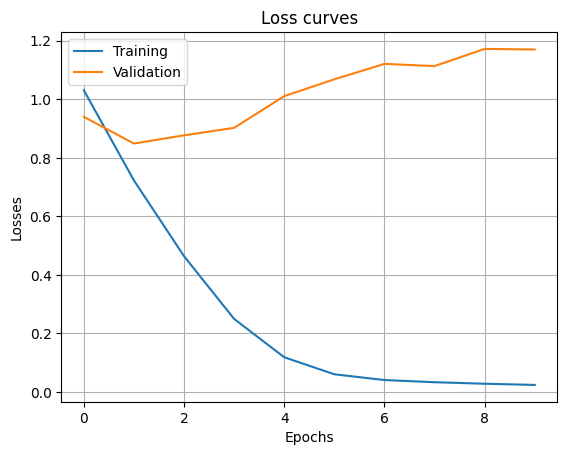

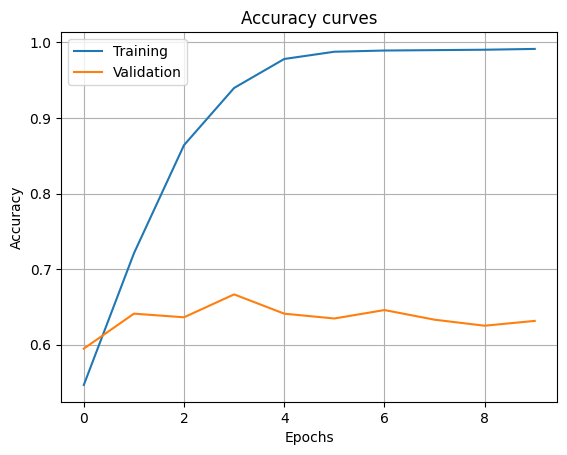

In [11]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss curves")
plt.legend()
plt.grid(1)
plt.show()


plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()
plt.grid(1)
plt.show()

In [12]:
best_model.to(device)
best_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 62.04%
Confusion Matrix:
[[ 56  38  44   8]
 [ 13  75  30  28]
 [ 27  14 163  23]
 [  2   8   3  95]]


In [13]:
classes = ['PD', 'PR', 'CR', 'HLTHY']
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

Accuracy for class PD: 38.36%
Accuracy for class PR: 51.37%
Accuracy for class CR: 71.81%
Accuracy for class HLTHY: 87.96%


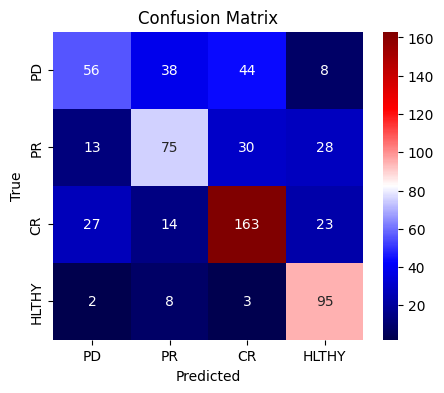

In [14]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='seismic', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()